In [1]:
from IPython import get_ipython


In [2]:
get_ipython().magic('matplotlib inline')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt



In [3]:
import numpy as np
import pandas as pd



In [4]:
import datetime as dt


 # Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func



In [6]:
engine = create_engine('sqlite:///hawaii.sqlite')


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


 # Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date (a date point) one year from the last date in data set.
perv_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= perv_year)
print(results.all())


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace= True)
print(df.to_string(index= False))

# Sort the dataframe by date
df = df.sort_index()
print(df.to_string(index=False))

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

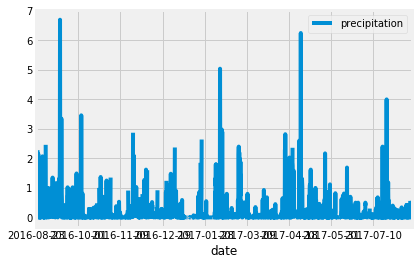

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
results = session.query(func.count(Station.station)).all()
station_df = pd.DataFrame()

In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
         func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

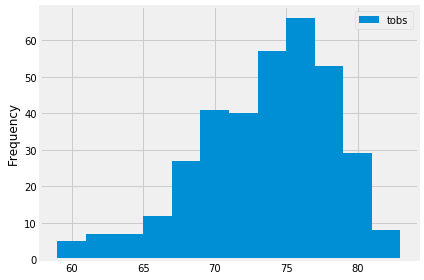

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281')\
                .filter(Measurement.date >= perv_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.head()
df.plot.hist(bins= 12)
plt.tight_layout()

In [18]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date = None, end_date = None):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs),func.max(Measurement.tobs)]
    results = session.query(*sel).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()
    
    return list(np.ravel(results))

In [19]:
# call calc_temps function to determine stats in June 2017
start = '2017-06-01'
end = '2017-06-30'
calc_temps(start_date=start, end_date= end)

[71.0, 77.21989528795811, 83.0]

 # Challenge

In [20]:
# Identify key statistical data in June across all of the stations and years 

# select all data for all years, and filter onld June data using LIKE funtion
results = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date.like('%-06-%')).all()
# convert into a DataFrame
June_df = pd.DataFrame(results, columns = ['June_date', 'June_precipitation', 'June_temp'])
June_df.set_index(June_df['June_date'], inplace= True)

# Sort the dataframe by date
June_df = June_df.sort_index()
June_df.describe()
#print(June_df.to_string(index=False))

,June_precipitation,June_temp
count,1574.000000,1700.000000
mean,0.136360,74.944118
std,0.335731,3.257417
min,0.000000,64.000000
25%,0.000000,73.000000
50%,0.020000,75.000000
75%,0.120000,77.000000
max,4.430000,85.000000


In [21]:
# Determine key statistical data about the month of December.
results = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date.like('%-12-%')).all()
# convert into a DataFrame
Dec_df = pd.DataFrame(results, columns = ['Dec_date', 'Dec_precipitation', 'Dec_temp'])
Dec_df.set_index(Dec_df['Dec_date'], inplace= True)

# Sort the dataframe by date
Dec_df = Dec_df.sort_index()
Dec_df.describe()

#print(Dec_df.to_string(index=False))

,Dec_precipitation,Dec_temp
count,1405.000000,1517.000000
mean,0.216819,71.041529
std,0.541399,3.745920
min,0.000000,56.000000
25%,0.000000,69.000000
50%,0.030000,71.000000
75%,0.150000,74.000000
max,6.420000,83.000000


 # Comparison Analysis:
 *Based on a comparison of precipitation and temperature between June and December from 2010 to 2017 across all observation stations, it’s possible to notice the following statistical information:*
 - Over 7 years, there are 1574 precipitations occurred and 1700 temperatures  observed in June, higher than 1405 precipitations and 1517 temperatures  observed in December. The different (1700-1517 = 183) between two observations counts that indicate the data of Dec, 2017 not included in database.
 - Comparing of precipitation, the mean (0.217) and median (0.03) of December are higher than June’s mean (0.136) and median (0.02), respectively.
 - For precipitation derivative indicators, December also had higher Standard Deviations and Maximum precipitation. In December, standard deviation (0.541) is higher than June’s standard deviation (0.336). The minimum of both December and June are zero, and December maximum (6.42) is higher than June (4.43).
 - Comparing of temperatures, it apparently shows that June’s temperature indicators are higher than December.

 # Analysis Limitation Recommendation:
 1. The lack of data in December, 2017  may cause less reliable of data. The database should generate more recently winter data to compare summer and winter precipitation.
 2. In addition of statistical summery, various features and plots may help us better analyze the seasonal weather. For example, line plots would be able to  provide quick and easy way to show time-varying. Histogram plots would tell us frequency of precipitation as well as temperature for both December and Jane.
 3. For seasonal analysis, we need filter more detail precipitation and temperatures for Spring and Autumn.